In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import xgboost as xgb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [14]:
# Load datasets
train = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
test = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')

In [15]:
# Prepare data
X_train = train.drop('label', axis=1).values.reshape(-1, 28, 28, 1) / 255.0
y_train = tf.keras.utils.to_categorical(train['label'].values)
X_test = test.drop(test.columns[0], axis=1).values.reshape(-1, 28, 28, 1) / 255.0

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Define One-Cycle Learning Rate Policy
def one_cycle_lr(epoch, max_lr, total_epochs, start_lr=None, final_lr=None):
    if start_lr is None:
        start_lr = max_lr / 10
    if final_lr is None:
        final_lr = start_lr / 1000
    if epoch < total_epochs / 2:
        lr = (max_lr - start_lr) / (total_epochs / 2) * epoch + start_lr
    else:
        lr = (final_lr - max_lr) / (total_epochs / 2) * (epoch - total_epochs / 2) + max_lr
    return lr

total_epochs = 30
max_lr = 0.001
lr_callback = LearningRateScheduler(lambda epoch: one_cycle_lr(epoch, max_lr=max_lr, total_epochs=total_epochs))

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Model checkpoint to save the best model during training
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')

# Train the model with one-cycle policy
history = model.fit(X_train, y_train, epochs=total_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint, lr_callback])

Epoch 1/30
  69/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2029 - loss: 2.2449

W0000 00:00:1714074612.364200     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7392 - loss: 0.8806

W0000 00:00:1714074619.084402     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714074619.594358     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7393 - loss: 0.8804 - val_accuracy: 0.9690 - val_loss: 0.0946 - learning_rate: 1.0000e-04
Epoch 2/30
  46/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9603 - loss: 0.1444

W0000 00:00:1714074620.106243     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9603 - loss: 0.1363 - val_accuracy: 0.9825 - val_loss: 0.0523 - learning_rate: 1.6000e-04
Epoch 3/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9769 - loss: 0.0821 - val_accuracy: 0.9882 - val_loss: 0.0386 - learning_rate: 2.2000e-04
Epoch 4/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9827 - loss: 0.0582 - val_accuracy: 0.9903 - val_loss: 0.0324 - learning_rate: 2.8000e-04
Epoch 5/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9848 - loss: 0.0494 - val_accuracy: 0.9910 - val_loss: 0.0280 - learning_rate: 3.4000e-04
Epoch 6/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9876 - loss: 0.0407 - val_accuracy: 0.9915 - val_loss: 0.0289 - learning_rate: 4.0000e-04
Epoch 7/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9899 - loss: 0.0309 - val_accuracy: 0.9927 - val_loss: 0.0226 - learning_rate: 4.6000e-04
Epoch 8/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accurac

In [17]:
# Load the best model and predict on the test set
model.load_weights('best_model.keras')
test_predictions = model.predict(X_test)
test_predicted_classes = np.argmax(test_predictions, axis=1)

122/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1714074735.409299     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


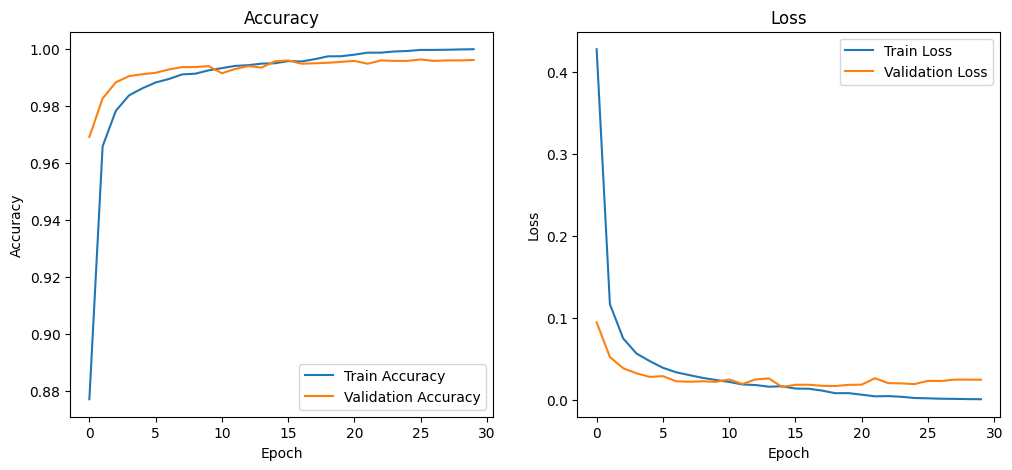

In [18]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


W0000 00:00:1714074736.893140     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


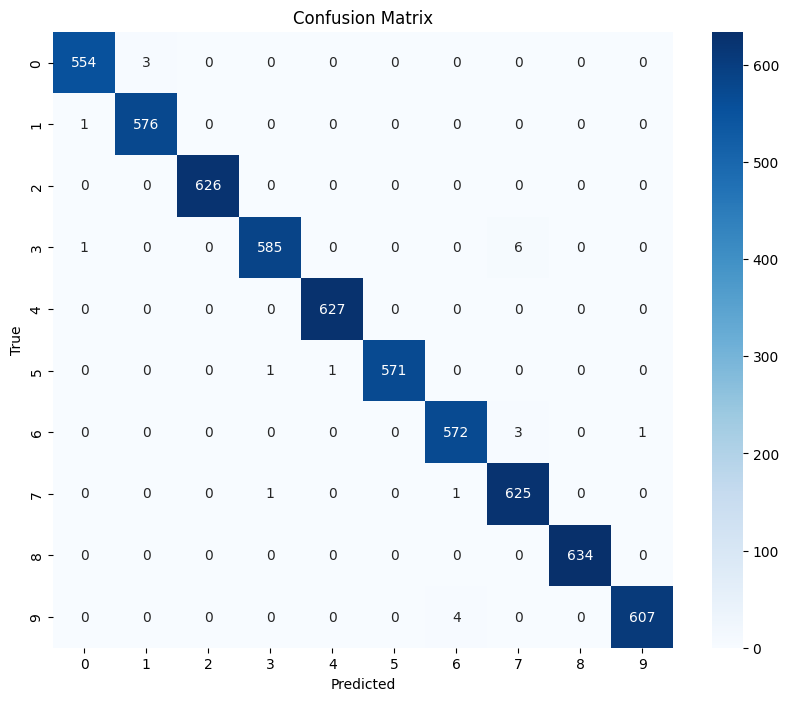

In [19]:
# Plot confusion matrix 

y_val_classes = np.argmax(y_val, axis=1)
val_preds_classes = np.argmax(model.predict(X_val), axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_val_classes, val_preds_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Prepare submission file
submission_df = pd.DataFrame({
    'id': np.arange(1, len(test_predicted_classes) + 1),
    'label': test_predicted_classes
})
submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)
print("Submission file for NN created!")
print(submission_df.head())

In [21]:
# Prepare the submission DataFrame using the IDs from the test dataset
submission_df = pd.DataFrame({
    'id': test.iloc[:, 0],  # Use the first column from the test DataFrame as ID
    'label': test_predicted_classes
})

# Save the DataFrame to a CSV file for submission
submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)
print("Submission file for NN created!")
print(submission_df.head())


Submission file for NN created!
   id  label
0   0      3
1   1      0
2   2      2
3   3      6
4   4      7
